<a href="https://colab.research.google.com/github/MichaelDeng03/GenAI_Agents/blob/main/all_agents_tutorials/art_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Art Agent
This tutorial will walk through the creation of an AI Agent that helps you explore and learn art!

### Overview
For knowledge retrieval, this tutorial uses [LightRAG](https://github.com/HKUDS/LightRAG) which is knowledge graph based RAG implementation. Compared to GraphRAG, LightRAG is more accurate for single topic datasets, and uses 1,000x less tokens for retrieval. Furthermore, documents can be added to LightRAG incrementally without rebuilding the knowledge graph. See the full results in the [paper](https://arxiv.org/abs/2410.05779).

For the agent itself, we use LangGraph.

### Outline
0. [Setup](#setup)
1. [Data Preparation + RAG](#data-preparation--rag)
2. [Agent Creation](#agent-creation)
3. [Final App](#final-app)

### Setup

#### Environment

This tutorial uses openai embedding models. While there are alternatives, we recommend using the openai models for the best results.

```
export OPENAI_API_KEY=sk....
```

In [11]:
!uv pip install lightrag-hku aioboto3 numpy ollama openai tenacity aioboto3 transformers torch tiktoken nano_vectordb neo4j oracledb textract setuptools pyvis sqlalchemy langchain_community langchain_openai sqlmodel ipywidgets==7.7.1 asyncio markdown langgraph

Using Python 3.12.6 environment at /Users/kentgang/git2/GenAI_Agents/.venv
Resolved 185 packages in 253ms                                       
⠙ Preparing packages... (0/3)                                                   
⠙ Preparing packages... (0/3)-------     0 B/28.39 KiB                  
langgraph-sdk ------------------------------     0 B/28.39 KiB
⠙ Preparing packages... (0/3)----     0 B/121.96 KiB                    
langgraph-checkpoint ------------------------------     0 B/22.90 KiB
langgraph-sdk ------------------------------     0 B/28.39 KiB
⠙ Preparing packages... (0/3)----     0 B/121.96 KiB                    
langgraph-checkpoint ------------------------------     0 B/22.90 KiB
langgraph-sdk ------------------------------ 16.00 KiB/28.39 KiB
⠙ Preparing packages... (0/3)----     0 B/121.96 KiB                    
langgraph-checkpoint ------------------------------ 14.90 KiB/22.90 KiB
langgraph-sdk ------------------------------ 16.00 KiB/28.39 KiB
⠙ Preparing pa

In [82]:
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, TwoByTwoLayout, Text, AppLayout, GridspecLayout
import ipywidgets as widgets
from IPython.display import display, Markdown
from IPython.display import Markdown

import json
import os
import operator
import random
from datetime import datetime
from typing import Any, Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from IPython.display import Image, display, Markdown

from langgraph.graph import StateGraph, END
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image as IPImage

from lightrag.llm import gpt_4o_mini_complete
from lightrag import LightRAG, QueryParam
from dotenv import load_dotenv

import markdown
from pprint import pprint

In [13]:
def get_artwork_image_url(url: str):
    """
    Gets an artwork image from its URL.
    """
    import requests
    from bs4 import BeautifulSoup as bs

    url = f"https://wikiart.org{url}"
    response = requests.get(url)
    soup = bs(response.text, "html.parser")
    img = soup.find("img", {"itemprop": "image"})
    # return Image(url=img.get("src"))
    return img.get("src")

### Data Preparation + RAG

#### Data Preparation

We scraped data from [wikiart](https://wikiart.org/) using a combination of requests and beautiful soup. 

We provide a preprocessed, limited dataset of this data for the tutorial found in `data/artinfo.json`. 

Preprocessed data for each artwork looks like:

```plaintext
Artwork Name: {artwork_name}
Artwork Genre: {genre_list}
Artwork Media: {media_list}
Wikiart URL: https://www.wikiart.org{wikiart_slug}

Wikipedia Article:
{wiki_article}
```


#### LightRAG


In [146]:
artwork_info = None
with open('./data/artinfo.json', 'r') as f:
    artwork_info = json.load(f)['info']
print(len(artwork_info))
print(artwork_info[0])

78

Artist: Frederick McCubbin
Artwork Name: Down on his luck
Artwork Genre: genre painting
Artwork Media: canvas,oil
Wikiart URL: https://www.wikiart.org/en/frederick-mccubbin/down-on-his-luck-1889

Wikipedia Article:
 The painting was owned by William Fergusson up to 1986 until it was purchased by the Art Gallery of Western Australia in Perth. for the famous 9 by 5 Impression Exhibition. The scene was staged near the Box Hill artists' camp outside Melbourne, but it is thought that McCubbin would have made additional studies of Abrahams under studio conditions.roclaims the absence of all self-pity ... McCubbin's picture is thoroughly Australian in spirit." The surrounding bush is painted in subdued tones, reflecting his somber and contemplative mood.



In [145]:
from lightrag.llm import gpt_4o_mini_complete
from lightrag import LightRAG, QueryParam

import nest_asyncio

nest_asyncio.apply()
WORKING_DIR = "./data"
rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=gpt_4o_mini_complete,
)

INFO:lightrag:Logger initialized for working directory: ./data
INFO:lightrag:Load KV llm_response_cache with 0 data
INFO:lightrag:Load KV full_docs with 0 data
INFO:lightrag:Load KV text_chunks with 0 data
INFO:nano-vectordb:Init {'embedding_dim': 1536, 'metric': 'cosine', 'storage_file': './data/vdb_entities.json'} 0 data
INFO:nano-vectordb:Init {'embedding_dim': 1536, 'metric': 'cosine', 'storage_file': './data/vdb_relationships.json'} 0 data
INFO:nano-vectordb:Init {'embedding_dim': 1536, 'metric': 'cosine', 'storage_file': './data/vdb_chunks.json'} 0 data


In [150]:
import time

# Create the RAG database
batch_size = 30

# Loop through the list in batches of 30 to avoid rate limits
for i in range(0, len(artwork_info), 30):
    batch = artwork_info[i:i + batch_size]
    rag.insert(batch)
    time.sleep(15)

INFO:lightrag:[New Docs] inserting 30 docs
INFO:lightrag:[New Chunks] inserting 30 chunks
INFO:lightrag:Inserting 30 vectors to chunks
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:[Entity Extraction]...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


INFO:lightrag:Inserting 290 vectors to entities


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Inserting 233 vectors to relationships
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:H

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


⠋ Processed 30 chunks, 357 entities(duplicated), 273 relations(duplicated)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightrag:Inserting 288 vectors to entities
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


INFO:openai._base_client:Retrying request to /chat/completions in 0.473677 seconds


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:lightrag:Inserting 188 vectors to entities
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Inserting 139 vectors to relationships
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https:/

### Agent Creation

In [108]:
class ArtTourState(TypedDict):
    artwork: str 
    artwork_metadata: str
    artwork_description: str
    artwork_url: str
    art_request: str
    past_artworks: list[str]
    discussion_messages: list[str]

In [128]:
def get_artwork_url_from_name(state: ArtTourState):
    artwork_name = state['artwork']
    prompt = f"""
    What is the Wikiart URL for this artwork: {artwork_name}
    
    Return only the wikiart url in plain text.
    """
    return {"artwork_url": rag.query(prompt, param=QueryParam(mode="hybrid"))}
pprint(next_artwork_url := get_artwork_url_from_name({'artwork': "Down on his luck"}))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 68 relations, 9 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 42 entites, 60 relations, 8 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'artwork_url': 'https://www.wikiart.org/en/frederick-mccubbin/down-on-his-luck-1889'}


In [129]:
def describe_artwork(state: ArtTourState):
    artwork = state['artwork']
    metadata = rag.query(
        f"""What is the genre, media, and style of the following artwork: {artwork}. 
    Return the description in the following format:
    artwork name: <artwork name>
    artist: <artist>
    genre: <genre>
    media: <media>
    style: <style>
    
    Return this information and nothing else.
    """,
        param=QueryParam(mode="hybrid"),
    )

    dense_description = str(rag.query(f"Describe the imagery and context of {artwork} in 2 concise paragraphs.", param=QueryParam(mode="hybrid")))

    return {
        "artwork_metadata": metadata,
        "artwork_description": dense_description,
        "artwork_url": get_artwork_url_from_name(state)
    }
pprint(description := describe_artwork({"artwork": "Down on his luck"}))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 141 relations, 12 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 50 entites, 60 relations, 9 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 78 relations, 11 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 50 entites, 60 relations, 11 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 68 relations, 9 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 42 entites, 60 relations, 8 text units


{'artwork_description': '**Down on His Luck**, painted by Frederick McCubbin '
                        'in 1889, captures a poignant scene of a disheartened '
                        'swagman sitting by a campfire, reflecting on his '
                        'misfortunes. The imagery conveys a sense of solitude '
                        "and contemplation, as the swagman's expression "
                        'reveals the hardships he has faced. The surrounding '
                        'bush is depicted in subdued tones, enhancing the mood '
                        "of melancholy that permeates the artwork. McCubbin's "
                        'style employs loose brushwork characteristic of '
                        'Impressionism, with the rugged natural setting '
                        "complementing the individual's somber state, thus "
                        'creating a connection between the figure and the '
                        'environment.\n'
                        '\n'

In [136]:
def describe_artwork(state: ArtTourState):
    artwork = state['artwork']
    metadata = rag.query(
        f"""What is the genre, media, and style of the following artwork: {artwork}. 
    Return the description in the following format:
    artwork name: <artwork name>
    artist: <artist>
    genre: <genre>
    media: <media>
    style: <style>
    
    Return this information and nothing else.
    """,
        param=QueryParam(mode="hybrid"),
    )

    dense_description = str(rag.query(f"Describe the imagery and context of {artwork} in 2 concise paragraphs.", param=QueryParam(mode="hybrid")))

    return {
        "artwork_metadata": metadata,
        "artwork_description": dense_description,
        "artwork_url": get_artwork_url_from_name(state)
    }
pprint(description := describe_artwork({"artwork": r"Le D\u00e9part du vapeur de Folkestone"}))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 146 relations, 8 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 51 entites, 60 relations, 8 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 129 relations, 11 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 53 entites, 60 relations, 7 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:

{'artwork_description': '**Imagery and Context of Le Départ du vapeur de '
                        'Folkestone**\n'
                        '\n'
                        '"Le Départ du vapeur de Folkestone," painted by '
                        'Eugène Boudin, encapsulates a lively harbor scene '
                        'depicting the departure of a steamship from '
                        'Folkestone, a coastal town in England. The painting '
                        'showcases a bustling atmosphere with numerous figures '
                        'hastily boarding the boat, captured in vibrant colors '
                        "and fluid brushwork typical of Boudin's style. The "
                        'scene is adorned with ships and small boats, set '
                        'against a dramatically overcast sky that illuminates '
                        'the water, conveying a sense of movement and urgency. '
                        "The artist's focus on light effects enhances the "


In [130]:
def request_artwork(state: ArtTourState):
    description = state['art_request']
    prompt = """
    The user has requested the following for their next artwork. Choose a related artwork.
    {description}
    
    Return the name of the artwork and nothing else.
    """
    return {"artwork": rag.query(prompt, param=QueryParam(mode="hybrid"))}

def get_next_artwork(state: ArtTourState):
    
    prev_artwork = state['artwork_metadata']
    next_artwork = state['art_request']
    past_artworks = state['past_artworks']
    prompt = f"""You are an art tour guide. 
    The have discussed these artworks earlier in the tour: {past_artworks}  
    You just discussed this artwork:
    {prev_artwork}

    The user has requested the following for their next artwork. Choose a related artwork.
    {next_artwork}
    
    Return the name of the artwork and nothing else.
    """
    next_artwork = rag.query(prompt, param=QueryParam(mode="hybrid"))
    art_data = describe_artwork({'artwork': next_artwork})
    out =  {
        "artwork": next_artwork,
        "past_artworks": past_artworks + [prev_artwork],
        **art_data  # metadata + description
    }
    out.update(art_data)
    return out

pprint(next_artwork := get_next_artwork({
    "past_artworks": ["The Pink Dress", "The Ballet Class"],
    "artwork_metadata": description['artwork_metadata'],
    "art_request": "I want to see artworks by a different artist of the same genre."
}))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 151 relations, 9 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 38 entites, 60 relations, 8 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 142 relations, 12 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 51 entites, 60 relations, 8 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 152 relations, 12 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 49 entites, 60 relations, 7 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/c

{'artwork': '**The Sower**',
 'artwork_description': '**The Sower**, created by Slovene Impressionist '
                        'painter Ivan Grohar in 1907, is a significant artwork '
                        'that portrays a peasant sowing seeds in a verdant '
                        'field, embodying themes central to Slovene culture '
                        'and agrarian life. The painting utilizes vibrant '
                        'colors and dynamic brushstrokes to depict both the '
                        'labor and the connection to nature inherent in '
                        'farming traditions. Grohar’s work reflects the '
                        'importance of agriculture in Slovenian identity, '
                        'showcasing how such rural activities are intertwined '
                        'with the broader cultural narrative of the nation.\n'
                        '\n'
                        'The imagery in **The Sower** goes beyond the '
                      

In [131]:
with open('./data/artinfo.json', 'r') as f:
    art_json = json.load(f)
artworks = [art_info.split('\n')[2].split(': ')[1] for art_info in art_json['info']]
def get_random_art():
    out = {"artwork": random.sample(artworks, 1)[0]}
    art_data = describe_artwork(out)
    out.update(art_data)
    return out
pprint(random_artwork := get_random_art())

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 138 relations, 8 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 50 entites, 60 relations, 9 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Local query uses 60 entites, 151 relations, 7 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:lightrag:Global query uses 53 entites, 60 relations, 7 text units
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:H

{'artwork': 'Le Départ du vapeur de Folkestone',
 'artwork_description': '**Imagery of Le Départ du vapeur de Folkestone**\n'
                        '\n'
                        'Le Départ du vapeur de Folkestone is a captivating '
                        'oil-on-canvas painting that captures a bustling scene '
                        'at a port during the 19th century. The artwork '
                        'vividly illustrates a moment of departure, with a '
                        'steamship ready to leave the dock. The atmosphere is '
                        'filled with a sense of movement and anticipation, as '
                        'figures are seen boarding the vessel amidst a flurry '
                        'of activity. The smoke billowing from the ship adds '
                        'dynamic energy to the composition, while the '
                        'background features the calm waters of the sea, '
                        'juxtaposed with the lively crowd gathered on

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

In [152]:
def tour_introduction():
    pass

def conclude_tour():
    pass

def display_artwork():
    pass

def choose_next_artwork():
    pass

def discuss():
    """
    Discuss the artwork with the user
    """
    pass

def prompt_user():
    pass

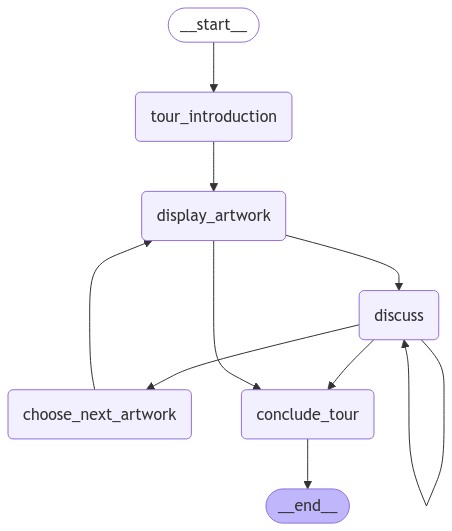

In [ ]:

workflow = StateGraph(ArtTourState)
# nodes
workflow.add_node('tour_introduction', tour_introduction)
workflow.add_node('display_artwork', display_artwork)
workflow.add_node('choose_next_artwork', choose_next_artwork)
workflow.add_node('discuss', discuss)
workflow.add_node('conclude_tour', conclude_tour)

workflow.add_edge('tour_introduction', 'display_artwork')
workflow.add_edge('display_artwork', 'discuss')
workflow.add_edge('discuss', 'discuss')
workflow.add_edge('discuss', 'choose_next_artwork')

workflow.add_edge('choose_next_artwork', 'display_artwork')
workflow.add_edge('display_artwork', 'conclude_tour')
workflow.add_edge('discuss', 'conclude_tour')

workflow.add_edge('conclude_tour', END)

# edges
workflow.set_entry_point('tour_introduction')
app = workflow.compile()
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
async def run_workflow(query: str)

### Final App

In [ ]:
def create_image_widget(artwork_url: str):
    return widgets.HTML(value=f'<img src="{get_artwork_image_url(artwork_url)}">')


def create_description_box(description: str):
    return widgets.HTML(markdown.markdown(description))
    # return widgets.HTML(value=f'<h1>{description}</h1>')


exit_loop = False

prompt_input = widgets.Text(value='helloworld')


def callback(widget):
    # Start workflow loop
    pass


prompt_input.on_submit(callback)

grid_layout = GridspecLayout(20, 1)
grid_layout[0, 0] = create_description_box("foo 1637")
grid_layout[1:12, 0] = create_image_widget('/en/pieter-codde/the-meagre-company-1637')
grid_layout[13, 0] = create_description_box("this is a llm response")
grid_layout[14, 0] = prompt_input

grid_layout

GridspecLayout(children=(HTML(value='<p>foo 1637</p>', layout=Layout(grid_area='widget001')), HTML(value='<img…

In [ ]:
# User Loop
current_image = "https://www.wikiart.org/en/pierre-auguste-renoir/ball-at-the-moulin-de-la-galette-1876"
description = describe_painting(current_image)
app_running = True
while app_running:
    while current_painting:
        

    